<a href="https://colab.research.google.com/github/diegoramfin/Backtestable-Alpha-Factor-Library/blob/main/Backtestable_Alpha_Factor_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alpha Factor Library: Momentum, Volatility, Mean Reversion

Simple Alpha indicator research system, showcasing a modular system design that allows for ease of deployment. Powered by machine learning to predict effectiveness of the indicator themselves.

In [ ]:
!pip install yfinance bt ta scikit-learn xgboost

In [45]:
#Intial Data Pull for the Backtesting Engine

import yfinance as yf
import pandas as pd

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
data = yf.download(tickers, start="2023-01-01", end="2024-12-31", auto_adjust=False)['Adj Close']
data = data.ffill()
display(data.head(10))
data.shape

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2023-01-03,123.470619,85.820000,88.588699,234.808945,108.099998
2023-01-04,124.744118,85.139999,87.554909,224.537659,113.639999
2023-01-05,123.421257,83.120003,85.686104,217.882874,110.339996
2023-01-06,127.962440,86.080002,86.819305,220.450668,113.059998
2023-01-09,128.485626,87.360001,87.495262,222.597076,119.769997
2023-01-10,129.058243,89.870003,87.892883,224.292618,118.849998
2023-01-11,131.782959,95.089996,90.974388,231.074829,123.220001
2023-01-12,131.703995,95.269997,90.586723,233.760254,123.559998
2023-01-13,133.036697,98.120003,91.570808,234.465912,122.400002


(501, 5)

In [46]:
#Momentum Factor Alpha Indicator

def momentum(close, lookback=252, skip =21):
  return close.pct_change(periods=lookback).shift(skip)

momentum_factor = momentum(data)

In [47]:
#Volatilty Factor Rolling Std Dev

def volatility(close,window=21):
  return close.pct_change().rolling(window=window).std()

volatility_factor = -volatility(data)

In [48]:
#Mean Reversion (Short-Term Reversal)

def mean_reversion(close, window=6):
  return -close.pct_change(window)

mean_reversion_factor = mean_reversion(data)

In [49]:
#Normalize & Rank Factors

def rank_normalize(factor_df):
  return factor_df.rank(axis=1, pct=True)

momentum_factor_rank = rank_normalize(momentum_factor)
volatility_factor_rank = rank_normalize(volatility_factor)
mean_reversion_factor_rank = rank_normalize(mean_reversion_factor)

#This is done to rank the alpha signals cross-sectionally the stocks.

In [50]:
#Portfolio Weights

combined_signal = ((0.4 * momentum_factor_rank) +
                  (0.3 * volatility_factor_rank) +
                  (0.3 * mean_reversion_factor_rank))

 #Long Short Logic, 20%/20% split

longs = combined_signal.apply(lambda x: x >= x.quantile(0.8)).astype(int)
shorts = combined_signal.apply(lambda x: x <= x.quantile(0.2)).astype(int)

weights = longs - shorts
weight = weights.div(weights.abs().sum(axis=1), axis=0) #Normalization

In [51]:
#Backtest Engine

daily_returns = data.pct_change()

shifted_weights = weights.shift()

portfolio_returns = (shifted_weights * daily_returns).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

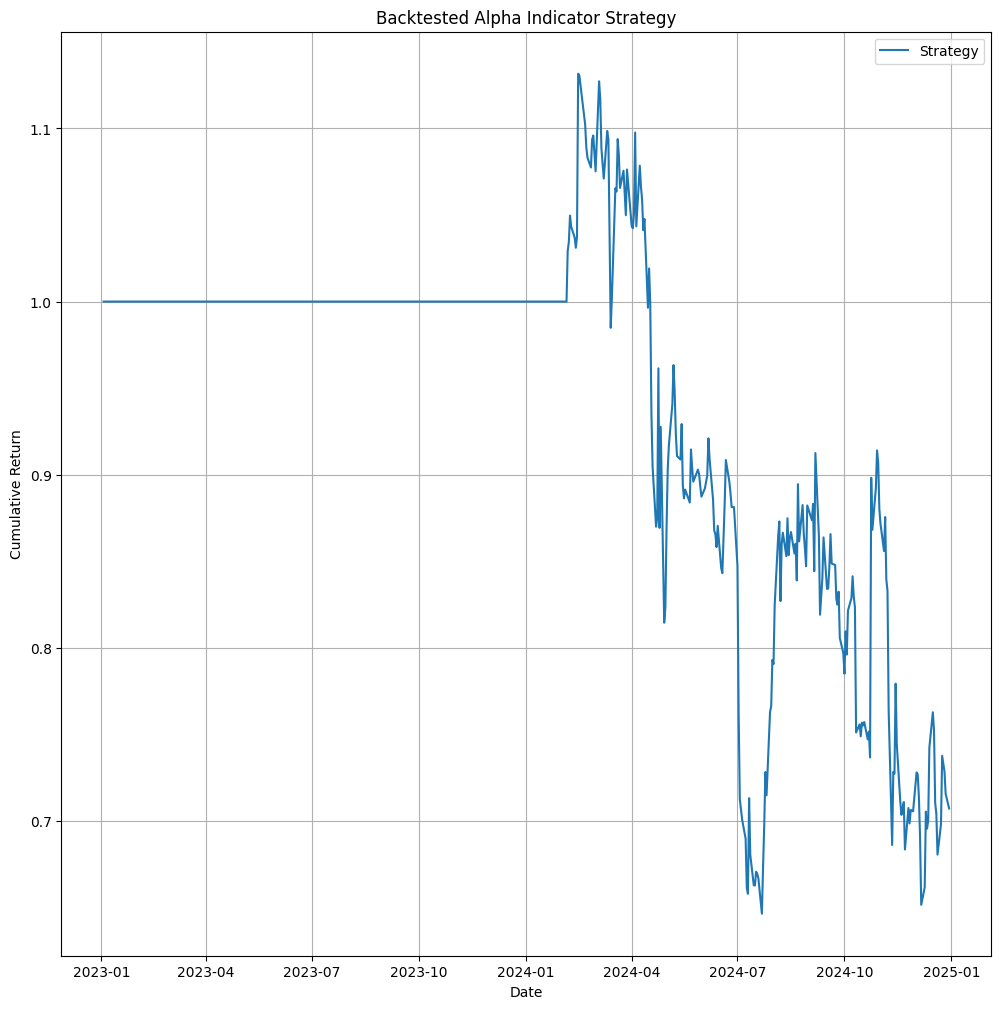

Date
2023-01-03    1.000000
2023-01-04    1.000000
2023-01-05    1.000000
2023-01-06    1.000000
2023-01-09    1.000000
                ...   
2024-12-23    0.698139
2024-12-24    0.737649
2024-12-26    0.728611
2024-12-27    0.715745
2024-12-30    0.707237
Length: 501, dtype: float64


In [52]:
#Visualize Backtesting Results

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

plt.plot(cumulative_returns, label='Strategy')

plt.title("Backtested Alpha Indicator Strategy")

plt.xlabel("Date")

plt.ylabel("Cumulative Return")

plt.legend()

plt.grid(True)

plt.show()

In [53]:
#Machine Learning Capabilities- Prep

import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_ml = combined_signal.stack().shift(1).dropna().to_frame('combined_signal_lag1')
y_ml = daily_returns.stack().shift(-1).reindex(X_ml.index).dropna().to_frame('future_return')

common_index = X_ml.index.intersection(y_ml.index)

X_ml = X_ml.loc[common_index]
y_ml = y_ml.loc[common_index]

ml_data = pd.DataFrame({
    'combined_signal_lag1': combined_signal.stack().shift(1),
    'future_return': daily_returns.stack().shift(-1)
}).dropna()

X_ml_df = ml_data[['combined_signal_lag1']]
y_ml_series = ml_data['future_return']

In [56]:
#XGB Regression Model

ml_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, random_state=42)
ml_model.fit(X_ml_df, y_ml_series)

current_signal_for_prediction = combined_signal.stack().to_frame('combined_signal_lag1')

current_signal_for_prediction = current_signal_for_prediction.dropna()

predicted_future_returns = pd.Series(ml_model.predict(current_signal_for_prediction),
                                     index=current_signal_for_prediction.index)

predicted_future_returns_df = predicted_future_returns.unstack()

predicted_future_returns_df = predicted_future_returns_df.reindex(index=daily_returns.index, columns=daily_returns.columns)

predicted_future_returns_df = predicted_future_returns_df.dropna(how='all')

#ML Model Predictions are used to determine longs and shorts
ml_longs = predicted_future_returns_df.apply(lambda x: x >= x.quantile(0.8), axis=1).astype(int)
ml_shorts = predicted_future_returns_df.apply(lambda x: x <= x.quantile(0.2), axis=1).astype(int)

#Calculates Raw ML Driven Weights
ml_weights = ml_longs - ml_shorts

#Normalizes the Weights
ml_weights_normalized = ml_weights.div(ml_weights.abs().sum(axis=1), axis=0)

#Shift Weights by one period to avoid look-ahead bias
shifted_ml_weights = ml_weights_normalized.shift(1)

#Align new weights
common_dates = shifted_ml_weights.index.intersection(daily_returns.index)
shifted_ml_weights = shifted_ml_weights.loc[common_dates]
daily_returns_aligned = daily_returns.loc[common_dates]

#New Weigths are Deployed Here
portfolio_returns_ml = (shifted_ml_weights * daily_returns_aligned).sum(axis=1)
cumulative_returns_ml = (1 + portfolio_returns_ml).cumprod()

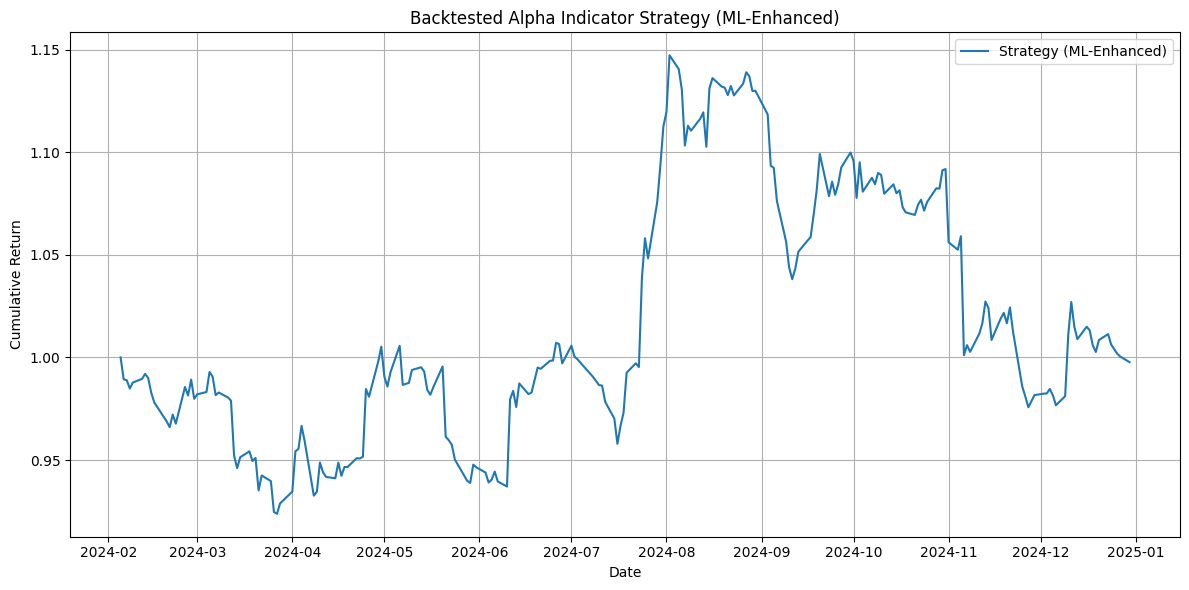


--- ML Model Performance (on training data) ---
R-squared on training data: 0.0322
Mean Squared Error on training data: 0.0005


In [57]:
#Visualize New Backtesting Results with New ML Driven Weights

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

plt.figure(figsize=(12, 6))

plt.plot(cumulative_returns_ml, label='Strategy (ML-Enhanced)')

plt.title("Backtested Alpha Indicator Strategy (ML-Enhanced)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- ML Model Performance (on training data) ---")
y_pred_train = ml_model.predict(X_ml_df)
print(f"R-squared on training data: {r2_score(y_ml_series, y_pred_train):.4f}")
print(f"Mean Squared Error on training data: {mean_squared_error(y_ml_series, y_pred_train):.4f}")

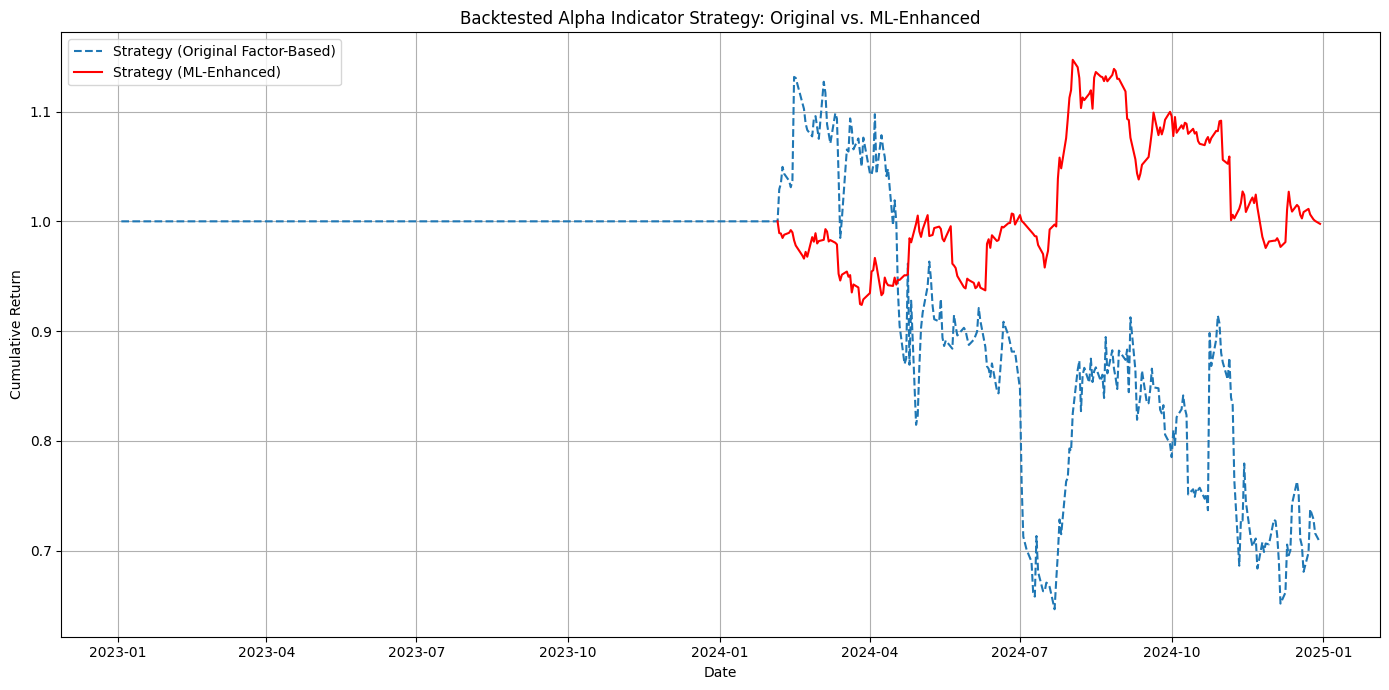


--- ML Model Performance (on training data) ---
R-squared on training data: 0.0322
Mean Squared Error on training data: 0.0005


In [58]:
#Compare Strategies Original vs. ML-Enhanced

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(cumulative_returns, label='Strategy (Original Factor-Based)', linestyle='--') # Original strategy
plt.plot(cumulative_returns_ml, label='Strategy (ML-Enhanced)', color='red') # ML-enhanced strategy

plt.title("Backtested Alpha Indicator Strategy: Original vs. ML-Enhanced")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- ML Model Performance (on training data) ---")
y_pred_train = ml_model.predict(X_ml_df)
print(f"R-squared on training data: {r2_score(y_ml_series, y_pred_train):.4f}")
print(f"Mean Squared Error on training data: {mean_squared_error(y_ml_series, y_pred_train):.4f}")